In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 5

In [3]:
mnist_train = dset.FashionMNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.FashionMNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [4]:
# Args:
# num_workers (int, optional): how many subprocesses to use for data

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

In [5]:
# basic_Autoencoder   
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Linear(28*28,20*20)
        self.nn1 = nn.Linear(20*20,10*10)
        self.nn2 = nn.Linear(10*10,20*20)
        self.decoder = nn.Linear(20*20,28*28)   
                
    def forward(self,x):
        x = x.view(batch_size,-1)
        encoded = self.encoder(x)
        encoded = self.nn1(encoded)
        decoded = self.nn2(encoded)
        out = self.decoder(decoded).view(batch_size,1,28,28)
        return out
    
# Convolutional_Autoencoder   
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),                            # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1),                           # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),                           # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)                                       # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),                          # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),                         # batch x 64 x 7 x 7
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),                    # batch x 128 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),                       # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1),                        # batch x 16 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1),                       # batch x 1 x 28 x 28
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
# Basic_Autoencoder
autoencoder = Autoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Convolutional_Autoencoder  
encoder = Encoder().to(device)
decoder = Decoder().to(device)
parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [10]:
autoencoder_loss_arr = []
for i in range(num_epoch):
    for j, [img, label] in enumerate(train_loader):
        x = img.to(device)
        optimizer.zero_grad()
        output = autoencoder.forward(x)
        loss = loss_fn(output, x)
        loss.backward()
        optimizer.step()

        if j % 100 == 0:
            autoencoder_loss_arr.append(loss.cpu().data.numpy())

In [11]:
# try:
#     encoder, decoder = torch.load('./model/conv_autoencoder.pkl')
#     print("\n--------model restored--------\n")
# except:
#     print("\n--------model not restored--------\n")
#     pass
convolutional_autoencoder_loss_arr = []
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)
        
        output = encoder(image)
        output = decoder(output)
        
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        
        if j % 100 == 0:
            # 모델 저장하는 방법
            # 이 역시 크게 두가지 방법이 있는데 여기 사용된 방법은 좀 단순한 방법입니다.
            # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        #         torch.save([encoder,decoder],'./model/conv_autoencoder.pkl')
            convolutional_autoencoder_loss_arr.append(loss.cpu().data.numpy())

In [13]:
with torch.no_grad():
    for j,[image,label] in enumerate(test_loader):
       
        image = img.to(device)
        
        optimizer.zero_grad()
        basic_output = autoencoder.forward(x)
        
        output = encoder(image)
        ac_output = decoder(output)

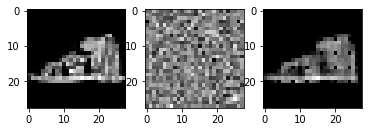

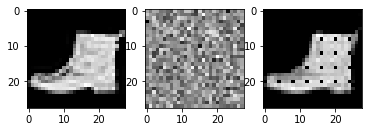

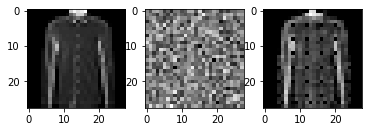

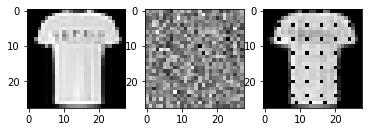

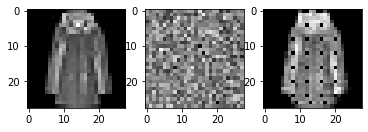

In [15]:
basic_out_img = torch.squeeze(basic_output.cpu().data)
ac_out_img = torch.squeeze(ac_output.cpu().data)

for i in range(5):
    plt.subplot(1,3,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(basic_out_img[i].numpy(),cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(ac_out_img[i].numpy(),cmap='gray')
    plt.show()

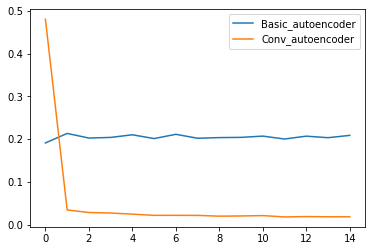

In [20]:
plt.plot(autoencoder_loss_arr, label="Basic_autoencoder")
plt.plot(convolutional_autoencoder_loss_arr, label="Conv_autoencoder")
plt.legend()
plt.show()